## Text Generation using LLM's

In this notebook, we explore various methods for generating text using Large Language Models (LLMs), specifically leveraging the Hugging Face library with pretrained models like GPT-2.

LLMs, or Large Language Models, are foundational for text generation. Essentially, these models are large transformer-based architectures trained to predict the next word or token in a sequence based on the preceding context. Given that they predict one token at a time, generating coherent and contextually appropriate sentences requires a more sophisticated approach than a straightforward model call. This process is known as autoregressive generation.

Autoregressive generation involves iteratively generating text by repeatedly calling the model with its previously generated output as input. The Hugging Face Transformers library simplifies this with its `generate()` method, which is designed for models with generative capabilities.

To illustrate how the generation process works, consider the sentence "This is a city." The process starts by tokenizing the input text, which is then fed into the pretrained LLM model. The model, which consists of embedding and multiple layers of deep neural networks (Decoders), performs a forward pass to produce logits for the next token. The token with the highest probability is selected as the next word, turning "This is a city" into "This is the city of dreams." This new phrase then serves as input for further autoregressive generation.

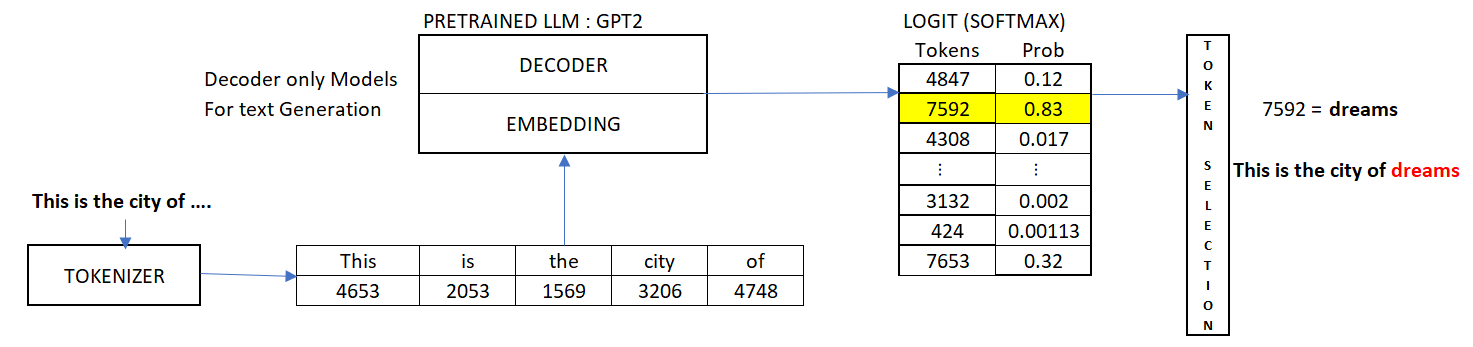

In [1]:
import torch
import evaluate
import numpy as np
import pandas as pd
import time
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoModelForSpeechSeq2Seq, AutoTokenizer,GenerationConfig
from transformers import TrainingArguments, Trainer
from transformers import set_seed

import warnings
warnings.filterwarnings('ignore')

## Text Generation

In [2]:
torch_device = torch.device('cpu')

In [3]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')

In [4]:
# Model

model = AutoModelForCausalLM.from_pretrained('gpt2',pad_token_id=tokenizer.eos_token_id,device_map='auto').to(torch_device)

In [5]:
# create input for the model
input_ = tokenizer('During my visit to america I realized',return_tensors='pt').to(torch_device)

### Greedy Search Method

In a greedy strategy, the model consistently picks the token it thinks is the most likely at each step. It doesn't consider alternative options or explore different possibilities; instead, it always selects the token with the highest probability and continues generating text based on this choice.

In [6]:
input_

{'input_ids': tensor([[ 7191,   616,  3187,   284, 45630,    64,   314,  6939]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [7]:
greedy_output = model.generate(**input_,max_new_tokens=40,pad_token_id=tokenizer.eos_token_id)

In [8]:
greedy_output

tensor([[ 7191,   616,  3187,   284, 45630,    64,   314,  6939,   326,   262,
           661,   286, 45630,    64,   389,   407,   262,   691,  3392,   508,
           389,  7195,   422,   428,  4369,    13,   314,   716,   407,  3436,
           287,   428,    13,   314,   423,  1775,   867,   661,   508,   423,
           587, 14641,   351,   428,  4369,    13,   314,   423]])

In [9]:
print(tokenizer.decode(greedy_output[0]))

During my visit to america I realized that the people of america are not the only ones who are suffering from this disease. I am not alone in this. I have seen many people who have been diagnosed with this disease. I have


Using a greedy strategy is both computationally efficient and straightforward, but it can lead to repetitive or overly deterministic outputs. Because the model always selects the most probable token at each step, it might miss out on the richness and variety of language, potentially resulting in less creative responses. This approach is short-sighted, focusing only on the immediate most probable token and not considering its broader impact on the entire sequence.

### Beam Search Method

#### Beam Search (with num_beams) 

Beam search is a strategy used in text generation where the model evaluates a set of the top "k" most probable tokens, rather than just the single most likely token at each step. This set of tokens is known as a "beam." The model generates possible sequences for each token in the beam and tracks their probabilities as it expands potential paths for each beam.

This process continues until the generated text reaches the desired length or until each beam encounters an "end" token. Ultimately, the model selects the sequence with the highest overall probability from all the beams as the final output.

In [10]:
set_seed(29)
beam_output = model.generate(**input_,max_new_tokens = 40, 
                             num_beams=3,
                             pad_token_id=tokenizer.eos_token_id)

In [11]:
print(tokenizer.decode(beam_output[0]))

During my visit to america I realized that there is a huge difference between the US and the UK. The US is a country that has been around for a long time, and has been around for a long time. The UK is a


#### Beam Search (with no repeat N-Grams)

In beam search, you might notice that the generated sentences can sometimes become repetitive. To improve the diversity of the output and reduce such repetitions, you can use the `no_repeat_ngram_size` parameter. This parameter helps limit the repetition of sequences by specifying an N-size for the n-grams, which are groups of N consecutive words.

By setting `no_repeat_ngram_size` to a specific value, you instruct the model to avoid generating any n-gram of that size more than once within the same sequence. For example, if `no_repeat_ngram_size` is set to 2, the model will prevent any bigram (two-word sequence) from repeating in the generated text. This helps produce more varied and coherent sentences by avoiding redundant phrasing and ensuring that the output maintains a richer linguistic structure.

In [12]:
set_seed(36)
beam_output = model.generate(**input_,max_new_tokens = 40,
                             num_beams=7,
                             no_repeat_ngram_size=2,
                            pad_token_id=tokenizer.eos_token_id)

In [13]:
print(tokenizer.decode(beam_output[0]))

During my visit to america I realized that there is a huge difference between the two countries.

In the United States, there are a lot of people who don't know what they are talking about. There are people like me who


#### Beam Search (Multiple sequences)

Another key advantage of beam search is that it allows for comparison among the top beams after the generation process is complete. Once the model has generated multiple sequences through the beams, you can evaluate and compare these sequences based on various criteria, such as coherence, relevance, or creativity.

In [14]:
set_seed(36)
beam_output = model.generate(**input_,max_new_tokens = 40, 
                             num_beams=7,
                             no_repeat_ngram_size=3,
                             num_return_sequences=4,
                             early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)

In [15]:
for i in range(4):
    print(tokenizer.decode(beam_output[i]))
    print()

During my visit to america I realized that there is a huge difference between the two countries.

When I first arrived in america, I had no idea what I was getting myself into. I didn't know what to expect.

During my visit to america I realized that there is a huge difference between the two countries.

When I first arrived in america, I had no idea what I was getting myself into. I didn't know what to expect,

During my visit to america I realized that there is a huge difference between the two countries.

When I first arrived in america, I had no idea what I was getting myself into. I didn't even know that I was

During my visit to america I realized that there is a huge difference between the two countries.

When I first arrived in america, I had no idea what I was getting myself into. I didn't know what to expect from



### Sampling Method

sampling involves selecting the next word based on its conditional probability distribution, which is derived from the context of the preceding words. This process means that the model generates the subsequent word by randomly choosing from the set of possible words, with each word being picked according to its likelihood as indicated by the probability distribution.

To elaborate, when generating text, the model evaluates the probability of each potential next word given the current context. Instead of always opting for the word with the highest probability, sampling introduces an element of randomness, allowing for a broader range of possible words to be selected. This can lead to more diverse and imaginative text, as it prevents the model from becoming too predictable or repetitive. However, while sampling can foster creativity and variability in the generated content, it might also produce less coherent or contextually accurate results 

#### Sampling Method

In [16]:
set_seed(27)
sample_output = model.generate(**input_, max_new_tokens=40,
                               do_sample=True, top_k=0,
                               pad_token_id=tokenizer.eos_token_id )

In [17]:
print(tokenizer.decode(sample_output[0]))

During my visit to america I realized - for the first time - that this small country for which nearly all of our needs of life came from behind has not been fully solved. With a 38 billion Dollar Keynesian Agenda the country of my


#### Sampling (with temperature)

Sampling can lead to incoherent or nonsensical text because of its inherent randomness. To improve coherence, you can sharpen the probability distribution by lowering the temperature of the softmax function, which increases the likelihood of high-probability words and reduces the chances of less probable ones.

In [18]:
set_seed(22)
sample_output = model.generate(**input_, max_new_tokens=40,
                               do_sample=True, top_k=0,
                               temperature=0.6,
                               pad_token_id=tokenizer.eos_token_id )

In [19]:
print(tokenizer.decode(sample_output[0]))

During my visit to america I realized that I was being followed by a very strange and dangerous group of people. relative to the people I was following. I was told that they were all very experienced and very well trained and had the ability


#### Top-K Sampling

In Top-K sampling, only the K most probable next words are considered, with their combined probability mass being redistributed among these top K candidates. This approach filters out less likely words, focusing the model’s generation on a smaller, more manageable set of options. GPT-2 employs this sampling method, which has significantly contributed to its success in generating coherent and engaging stories by balancing diversity with relevance in its outputs.

In [20]:
set_seed(25)
sample_output = model.generate(**input_, max_new_tokens=40,
                               do_sample=True, top_k=10,no_repeat_ngram_size=2,
                               temperature=0.6,
                               pad_token_id=tokenizer.eos_token_id )

In [21]:
print(tokenizer.decode(sample_output[0]))

During my visit to america I realized my own feelings of disappointment. The fact that the government has not been forthcoming in its response to the protests is a sign of the corruption in the country. It shows that this country is not a democracy


#### Top-P sampling (Nucleus Sampling)

n Top-p sampling, instead of selecting from a fixed number of the most likely words, the model chooses from the smallest set of words whose cumulative probability exceeds a specified threshold 
𝑝
p. The probability mass is then redistributed among this dynamic set of words. This method allows the size of the word set to adjust based on the probability distribution of the next word, accommodating both high and low-probability options more flexibly.

To visualize this, imagine you have a probability distribution for the next word. Top-p sampling starts by including words with the highest probabilities until their combined probability exceeds the threshold 
𝑝
p. The model then normalizes the probabilities within this set, ensuring that the most probable words are considered while maintaining flexibility in the number of words included based on their cumulative probability. This approach provides a balance between randomness and coherence, adapting to the distribution of possible next words dynamically.

In [22]:
set_seed(25)
sample_output = model.generate(**input_, max_new_tokens=40,
                               do_sample=True,top_k=0,no_repeat_ngram_size=2,
                               top_p=0.95,
                               pad_token_id=tokenizer.eos_token_id )

In [23]:
print(tokenizer.decode(sample_output[0]))

During my visit to america I realized my priority at the time was Afghanistan. It was not only Afghanistan but definitely Canada, we also wanted to push home some of the legacy that has been there. Despite the grittier nature of teaching
